# XBoost

- Proceso aplicado a cada ciudad por separado
- Se ha incluido GridSearch
- Se ha mejorado la imputación de datos, la mejor solución se obtiene eliminando las filas vacias pero la submision da problemas al faltar registros.
- Eliminaremos variables con poca correlacion y con muchos missing values para evitar imputar demasiados datos que desvien los resultados.
- Se usan la mediana de los valores climatologicos del último mes (4 semanas) ya que, aumenta la correlacion usando parte del historico.  


## Import libraries

In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
#import lightgbm as lgb

# Data imputation
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, KFold

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

import dengue_utils as dutils
import dsutils as du

import xgboost as xgb

## Load dataset

In [7]:
# Load dataset

features_train = pd.read_csv('../data/dengue_features_train.csv')
labels_train   = pd.read_csv('../data/dengue_labels_train.csv')

features_test = pd.read_csv('../data/dengue_features_test.csv')

dengue_dataset = pd.concat([features_train, features_test], axis = 0)

# Join train labes and features
dengue_dataset_labeled = dengue_dataset.merge(labels_train, 
                                           left_on = ['city', 'year', 'weekofyear'], 
                                           right_on = ['city', 'year', 'weekofyear'],
                                           how = 'outer')


features_test.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

## Exploration

In [8]:
dengue_dataset_labeled.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5.0
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4.0
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6.0


In [9]:
humidity_features = ['reanalysis_relative_humidity_percent',  'reanalysis_specific_humidity_g_per_kg', 'reanalysis_dew_point_temp_k']
precipitation_features = ['precipitation_amt_mm',  'reanalysis_precip_amt_kg_per_m2', 'reanalysis_sat_precip_amt_mm', 'station_precip_mm']
temperature_features = ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_tdtr_k',
                        'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c','station_min_temp_c']
vegetation_features = ['ndvi_ne', 'ndvi_nw','ndvi_se', 'ndvi_sw']

### san juan describe

In [10]:
dengue_dataset_labeled.loc[dengue_dataset_labeled['city']=='sj',:].describe().T

,count,mean,std,min,25%,50%,75%,max
year,1196.0,2001.326923,6.652597,1990.000000,1996.000000,2001.000000,2007.000000,2013.000000
weekofyear,1196.0,26.503344,15.020404,1.000000,13.750000,26.500000,39.250000,53.000000
ndvi_ne,962.0,0.050453,0.114467,-0.463400,-0.009308,0.051125,0.107100,0.500400
ndvi_nw,1136.0,0.060731,0.092158,-0.456100,0.007946,0.059040,0.107513,0.649000
ndvi_se,1176.0,0.177523,0.059411,-0.015533,0.137757,0.176014,0.213646,0.393129
ndvi_sw,1176.0,0.163152,0.056092,-0.063457,0.125214,0.162707,0.200418,0.381420
precipitation_amt_mm,1185.0,33.522270,42.274077,0.000000,0.760000,19.670000,49.810000,390.600000
reanalysis_air_temp_k,1188.0,299.227588,1.251881,295.938571,298.209643,299.352857,300.294286,302.200000
reanalysis_avg_temp_k,1188.0,299.334698,1.234097,296.114286,298.319643,299.439286,300.364286,302.164286
reanalysis_dew_point_temp_k,1188.0,295.155665,1.592483,289.642857,293.883929,295.492143,296.478571,297.795714


### iquitos describe

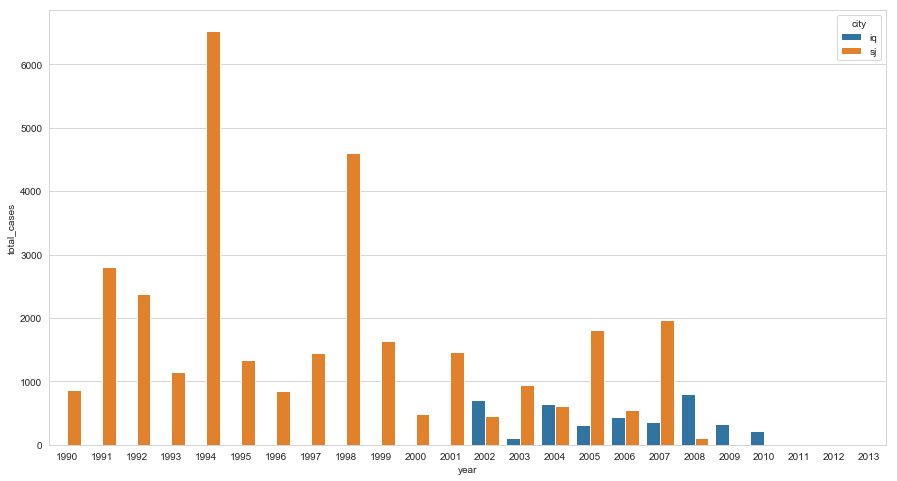

In [11]:
yearly_cases = dengue_dataset_labeled.groupby(['city', 'year'])['total_cases'].sum()
yearly_cases = yearly_cases.reset_index()

fig = plt.figure(figsize=(15, 8))
sns.barplot(x='year', y='total_cases', hue='city', data=yearly_cases)

In [12]:
# Fill missing values

train_features = humidity_features + precipitation_features + temperature_features + vegetation_features

res = pd.DataFrame()
for city in dengue_dataset_labeled.city.unique():
    
    dd_city = dengue_dataset_labeled.loc[dengue_dataset_labeled['city']==city,:]
    
    dd_city.loc[:,train_features] = dd_city.loc[:,train_features].fillna(method='ffill')

    scaler = StandardScaler()
    dd_city.loc[:,train_features] =  scaler.fit_transform(dd_city.loc[:,train_features])
    
    res = pd.concat([res, dd_city], axis=0)

res.shape

(1872, 25)

In [13]:
def show_lineplot(df, xvalue, yvalue, hue=None, figsize=(20, 10)):
    f, ax = plt.subplots(figsize=figsize)

    # Plot the responses for different events and regions
    ax = sns.lineplot(x=xvalue, y=yvalue, hue=hue, data=df)
    
    return ax
    

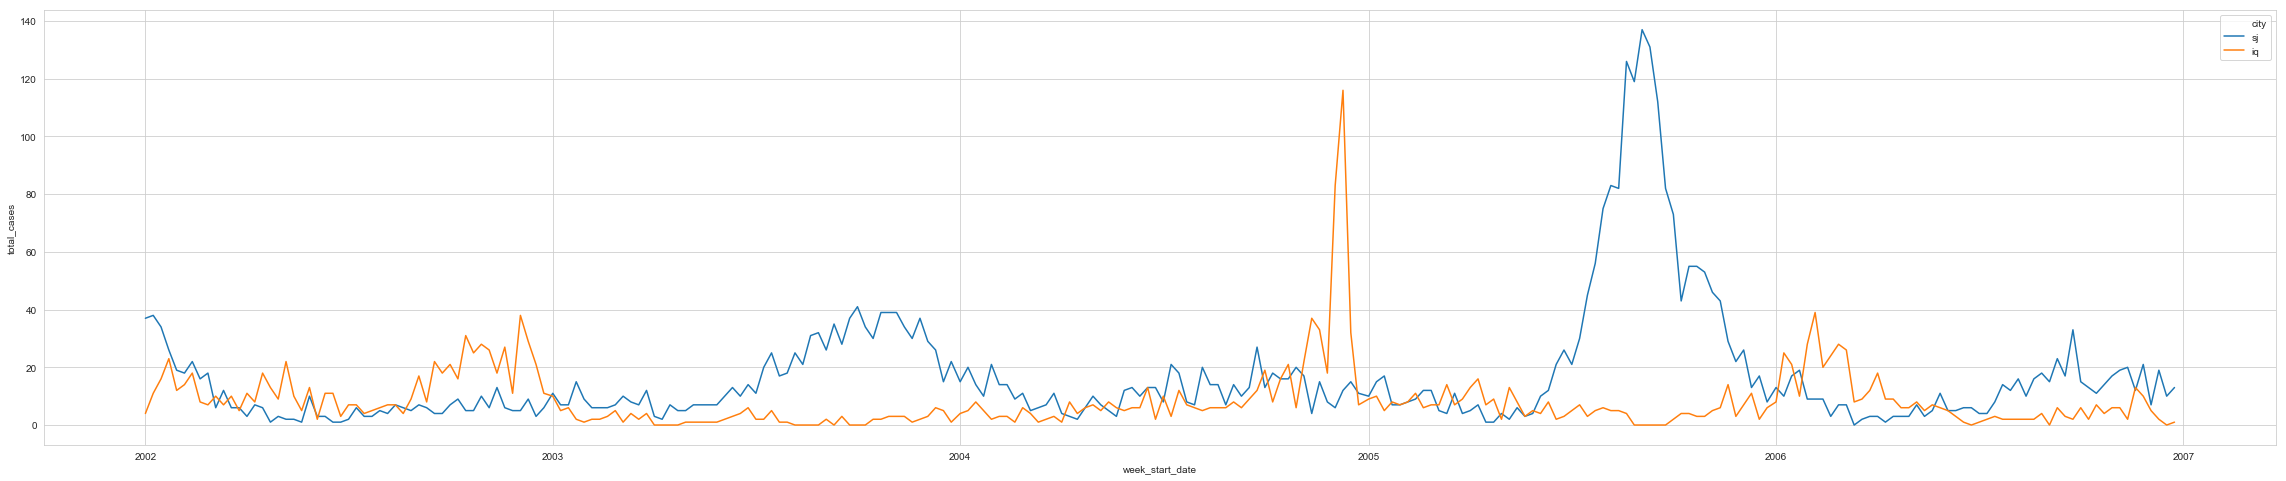

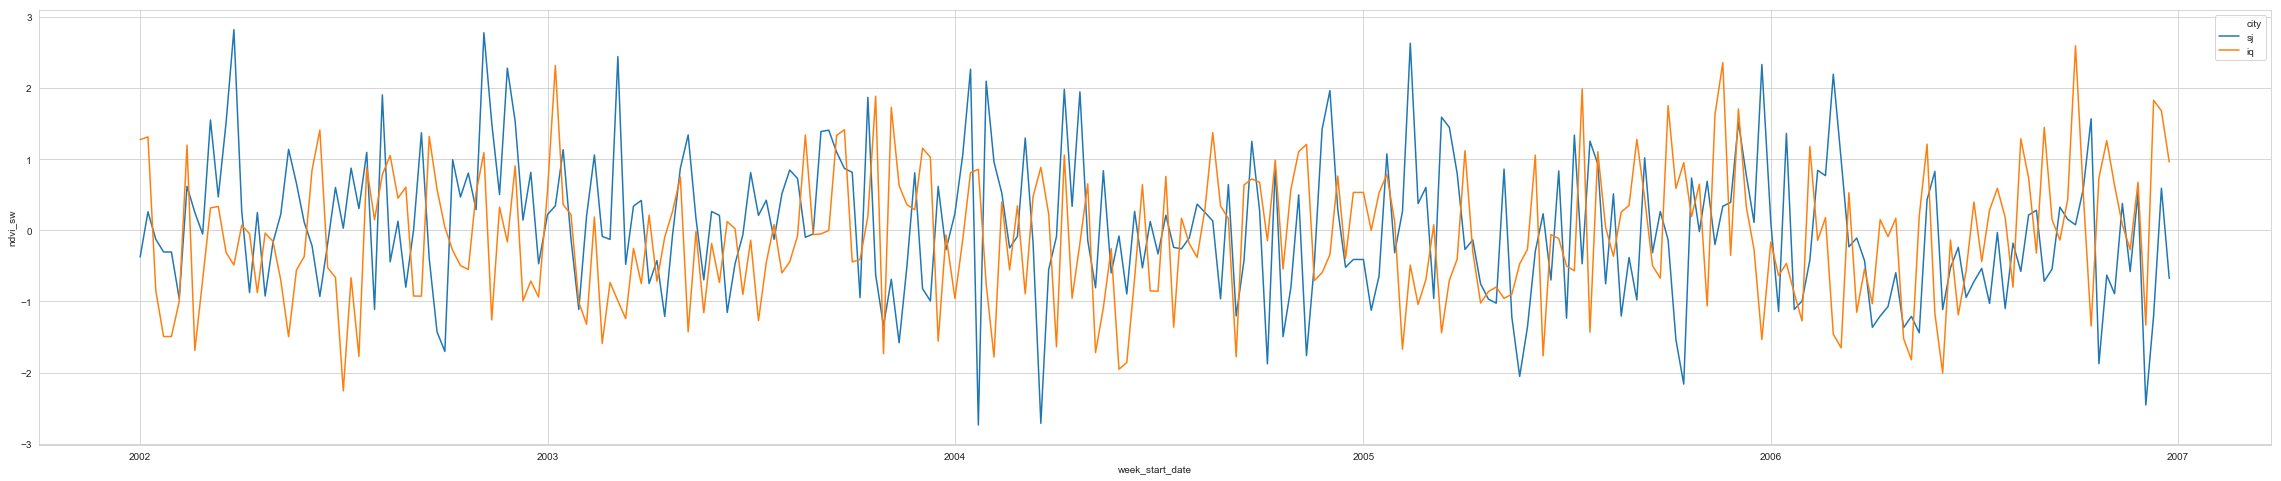

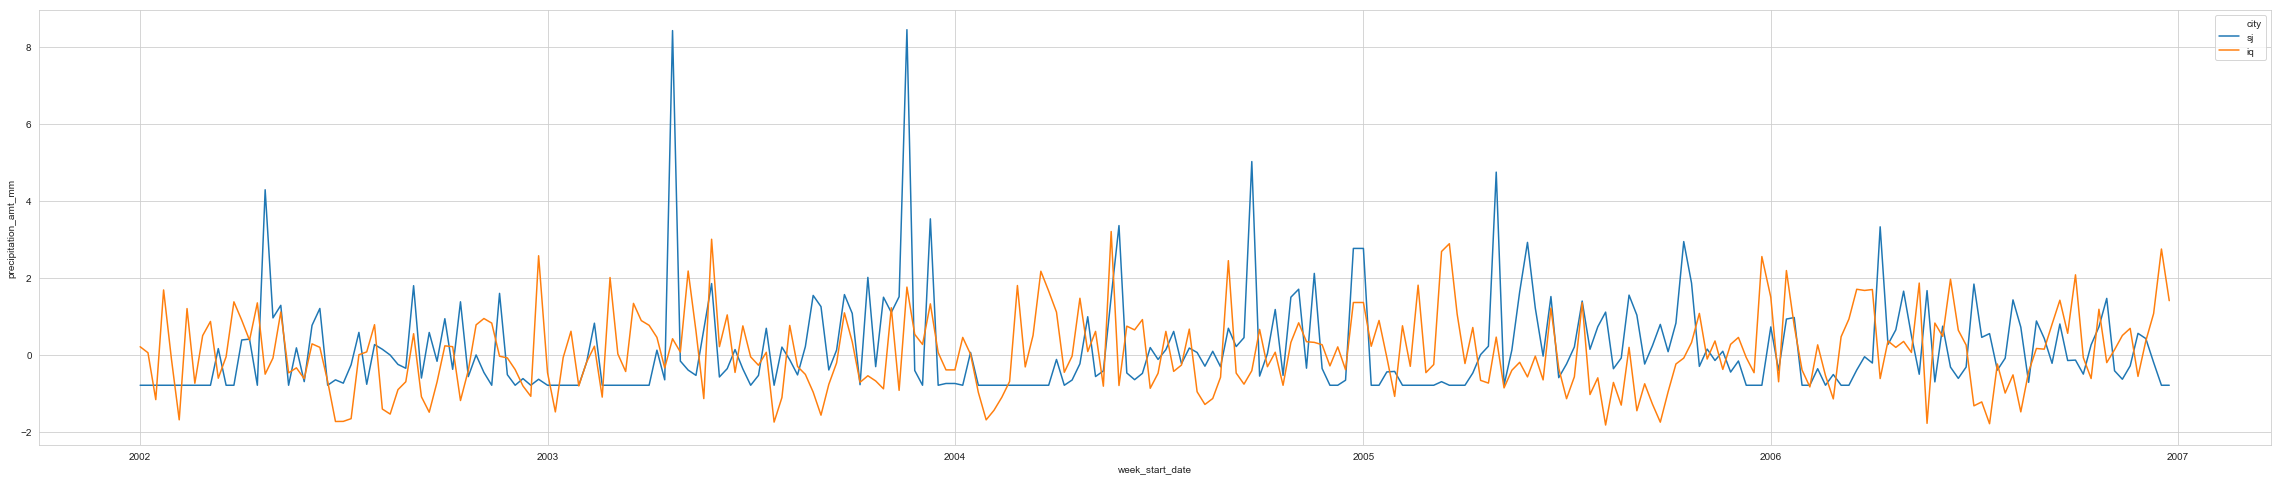

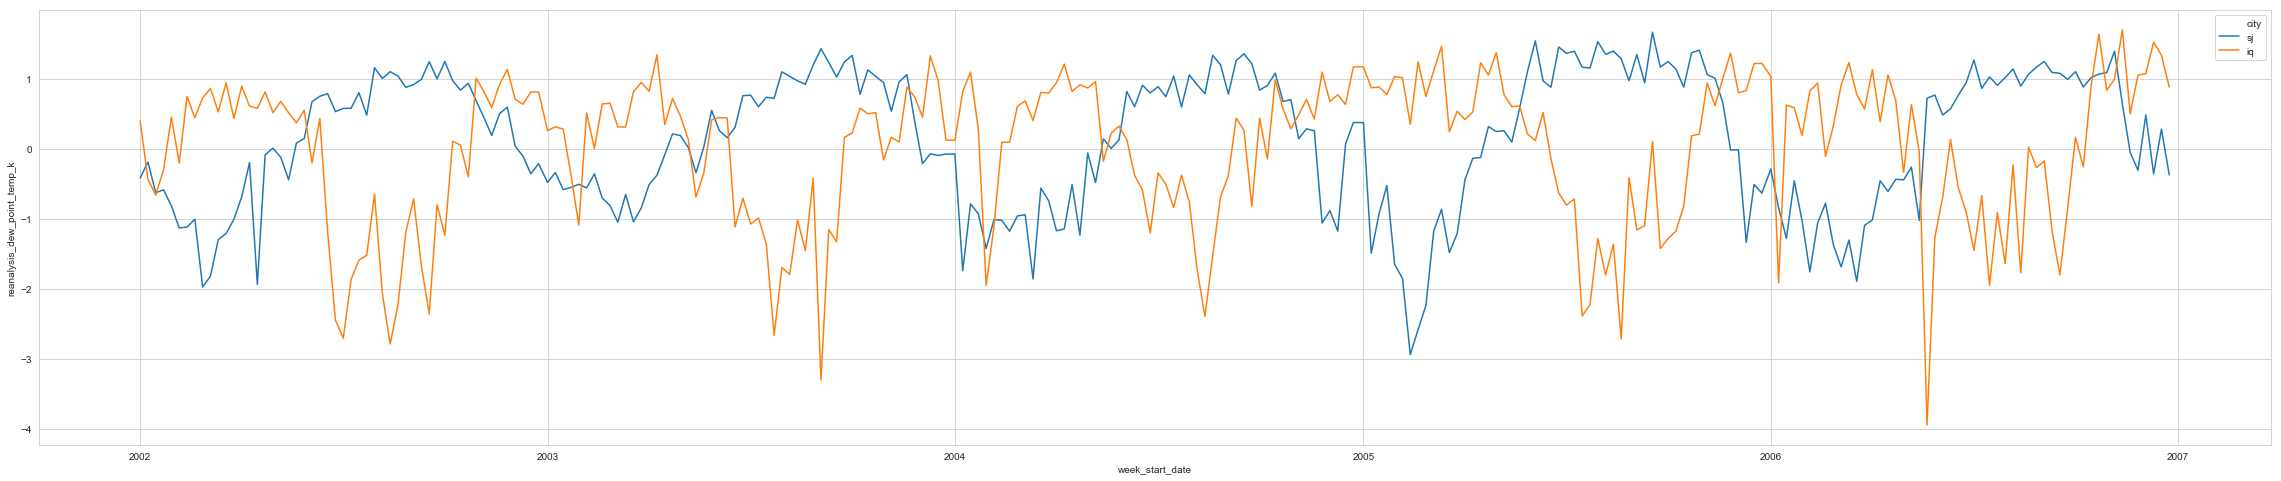

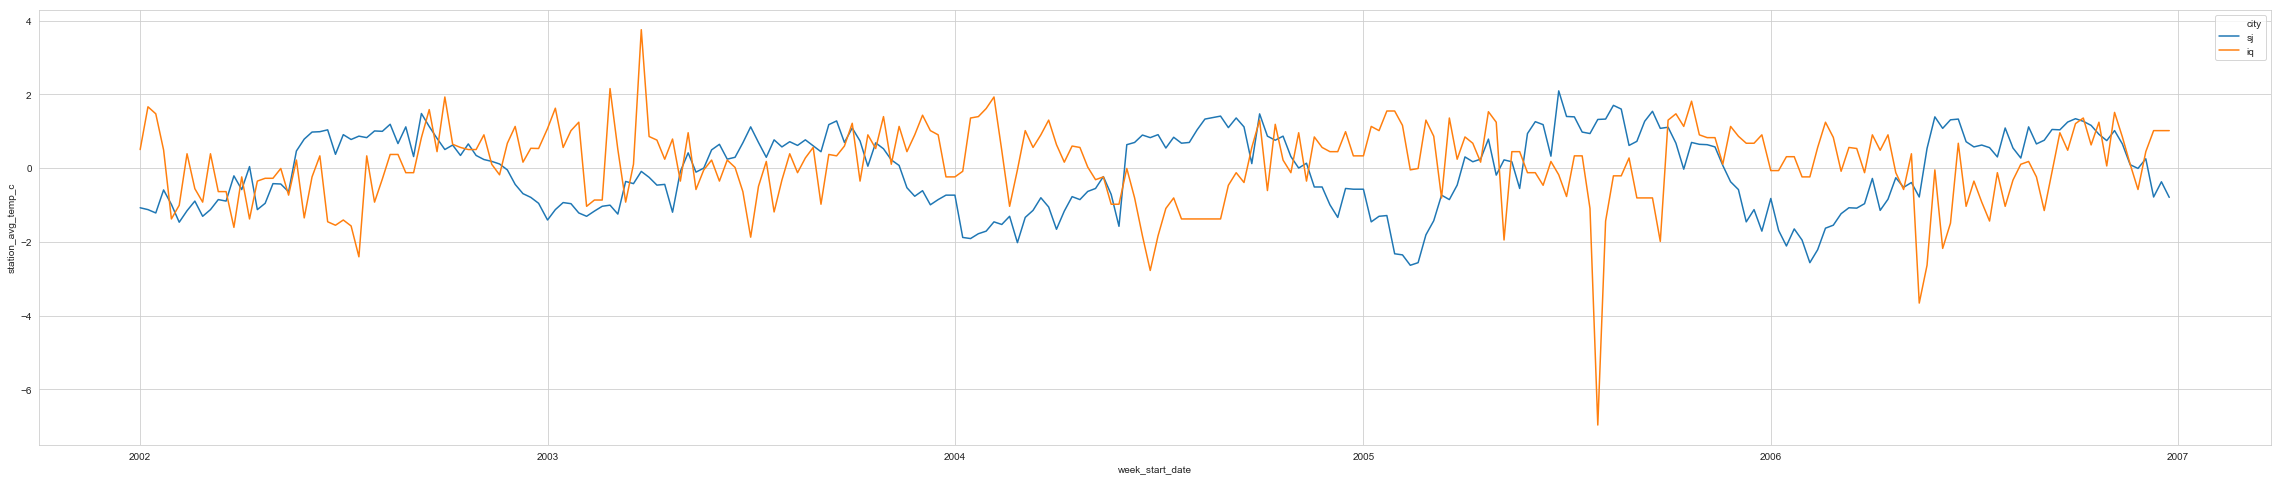

In [14]:
years = [2002, 2003, 2004, 2005, 2006]
res['week_start_date'] = pd.to_datetime(res['week_start_date'])
res_2004 = res.loc[res['year'].isin(years),:]

size = (20, 8)
show_lineplot(res_2004, xvalue='week_start_date', yvalue='total_cases', hue='city', figsize=(40, 8))
show_lineplot(res_2004, xvalue='week_start_date', yvalue='ndvi_sw', hue='city', figsize=(40, 8))
show_lineplot(res_2004, xvalue='week_start_date', yvalue='precipitation_amt_mm', hue='city', figsize=(40, 8))
show_lineplot(res_2004, xvalue='week_start_date', yvalue='reanalysis_dew_point_temp_k', hue='city', figsize=(40, 8))
show_lineplot(res_2004, xvalue='week_start_date', yvalue='station_avg_temp_c', hue='city', figsize=(40, 8))



In [15]:
dengue_dataset_labeled.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5.0
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4.0
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6.0


In [65]:
def train_and_predict(X_train, X_test):

    # Train the model
    model = smf.glm(formula = "total_cases ~ reanalysis_specific_humidity_g_per_kg + reanalysis_dew_point_temp_k + station_avg_temp_c", 
                    data = X_train, 
                    family = sm.families.NegativeBinomial()).fit()
    
    # Get predictions
    y_pred = model.predict(X_test).astype(int)
    y_pred = y_pred.reset_index()
    y_pred.columns = ['index', 'total_cases']

    # Add predictions to test dataset
    X_test = X_test.reset_index()
    X_test['y_pred'] = y_pred.loc[:,'total_cases']
    
    return X_test

In [70]:
import statsmodels.formula.api as smf 
import statsmodels.api as sm

train_features   = ['reanalysis_specific_humidity_g_per_kg','reanalysis_dew_point_temp_k', 'station_avg_temp_c']
label = "total_cases"

dataset_features = ['year', 'weekofyear', 'city', 'week_start_date'] + train_features + [label]

predictions = pd.DataFrame()

cities = dengue_dataset_labeled['city'].unique()

results = pd.DataFrame()

for city in cities:
    
    dd_city = dengue_dataset_labeled.loc[dengue_dataset_labeled['city'].isin([city]), dataset_features]

    # Fill missing values
    dd_city.loc[:,train_features] = dd_city.loc[:,train_features].fillna(method='ffill')

    # Use for each sample the median of the weather 12 weeks ago
    dd_city.loc[:,train_features] = dd_city.sort_values(['year', 'weekofyear'], ascending=True).loc[:,train_features].rolling(window=8).mean()

    dd_city.loc[:,train_features] = dd_city.loc[:,train_features].fillna(method='bfill')

    scaler = StandardScaler()
    dd_city.loc[:,train_features] =  scaler.fit_transform(dd_city.loc[:,train_features])

    # Get the train and test input datasets  
    dataset_train = dd_city.loc[dd_city['total_cases'].notnull(),:]
    dataset_test  = dd_city.loc[dd_city['total_cases'].isnull(),:]
    
    dataset_label = dataset_train.loc[:,'total_cases']
    
    #print(dataset_train.columns)
    #print(dataset_label.columns)
    
    # Split dataset in train and test
    X_train, X_test, y_train, y_test = train_test_split(dataset_train, dataset_label, test_size = 0.2, shuffle=False)
    
    y_pred = train_and_predict(X_train, X_test) 
    print("City: {}, Metrics: {}".format(city, du.get_metrics(y_pred.total_cases, y_pred.y_pred)))

    results = pd.concat([results, y_pred], axis=0)

print(results.shape)

City: sj, Metrics: (22.5, 0.19286225280261815, 0.37863763450656096)
City: iq, Metrics: (10.538461538461538, -0.9479483056399265, -0.9136328702167551)
(292, 10)


In [71]:
results.head()

,index,year,weekofyear,city,week_start_date,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,total_cases,y_pred
0,748,2004,38,sj,2004-09-16,1.243514,1.213887,1.308130,13.0,63
1,749,2004,39,sj,2004-09-23,1.273224,1.236703,1.228299,27.0,62
2,750,2004,40,sj,2004-09-30,1.265452,1.225988,1.288522,13.0,62
3,751,2004,41,sj,2004-10-07,1.287765,1.242249,1.224098,18.0,62
4,752,2004,42,sj,2004-10-14,1.255172,1.206576,1.138665,16.0,60


In [68]:
metrics_xgb = du.get_metrics(results.total_cases, results.y_pred)
print(metrics_xgb)

(18.23972602739726, 0.1785026471522546, 0.3005096453119034)


In [81]:
results_plot = results.loc[:,['week_start_date', 'city', 'total_cases', 'y_pred']]
results_plot.set_index(['week_start_date', 'city'], inplace=True)
results_plot = pd.DataFrame(results_plot.stack())
results_plot.reset_index(inplace=True)

In [84]:
results_plot.columns = ['week_start_date', 'city', 'type', 'total_cases']
results_plot.head()

,week_start_date,city,type,total_cases
0,2004-09-16,sj,total_cases,13.0
1,2004-09-16,sj,y_pred,63.0
2,2004-09-23,sj,total_cases,27.0
3,2004-09-23,sj,y_pred,62.0
4,2004-09-30,sj,total_cases,13.0


ValueError: Could not interpret input '0'

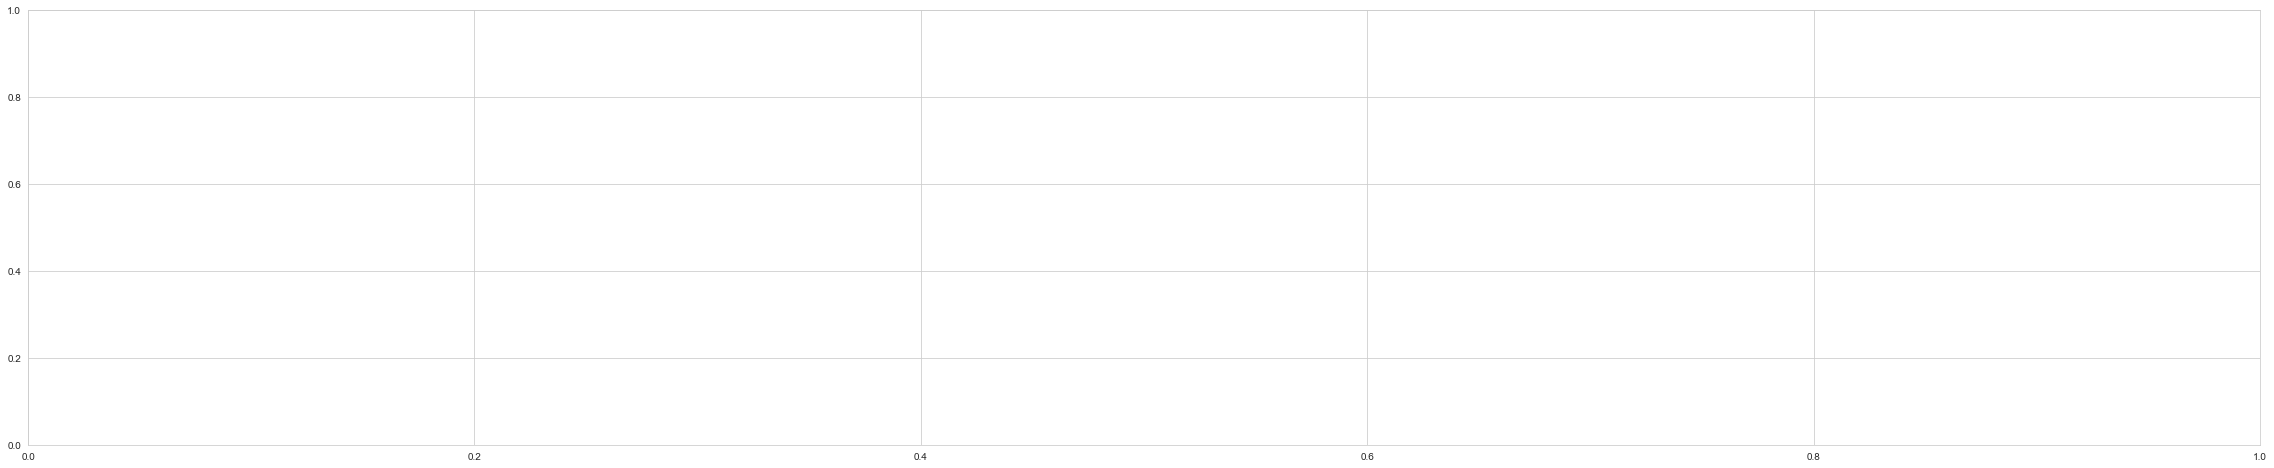

In [83]:
show_lineplot(results_plot.loc[results_plot['city']=='sj',:], xvalue='week_start_date', yvalue='0', hue='leve_2', figsize=(40, 8))

## Training model

In [ ]:
predictions = pd.DataFrame()
submision_predictions = pd.DataFrame()

train_features = dengue_dataset_labeled.columns.drop(['total_cases', 'city', 'week_start_date'])
climate_variables = dengue_dataset_labeled.columns.drop(['weekofyear', 'city', 'week_start_date','year', 'total_cases'])


train_features = ['reanalysis_specific_humidity_g_per_kg',  
                  'reanalysis_dew_point_temp_k',
                  'station_avg_temp_c']


dengue_dataset_lastweek = pd.DataFrame()

dengue_dataset_labeled['week_start_date'] = pd.to_datetime(dengue_dataset_labeled['week_start_date'])

cities = dengue_dataset_labeled['city'].unique()

for city in cities:

    dd_city = dengue_dataset_labeled[dengue_dataset_labeled['city'].isin([city])]

    
    # --------------------------------------
    # Preprocessing
    #---------------------------------------
    
    # Fill missing values
    dd_city.loc[:,train_features] = dd_city.loc[:,train_features].fillna(method='ffill')
    
    # Use for each sample the median of the weather 12 weeks ago
    for j, climate_variable in enumerate(climate_variables):
        dd_city[climate_variable] = (dd_city.sort_values(['city', 'year', 'weekofyear'],
                                                         ascending=True)[climate_variable]
                                     .rolling(window=8).median())
    # Fill missing values    
    dd_city.loc[:,train_features] = dd_city.loc[:,train_features].fillna(method='bfill')
    
    scaler = StandardScaler()
    dd_city.loc[:,train_features] =  scaler.fit_transform(dd_city.loc[:,train_features])
    
    # Get the train and test input datasets  
    dataset_train = dd_city.loc[dd_city['total_cases'].notnull(),:]
    dataset_test  = dd_city.loc[dd_city['total_cases'].isnull(),:]
    
    dataset_label = dataset_train['total_cases']
    dataset_train = dataset_train.drop(['total_cases'], axis=1)
    
    # Feature selection
    
    dataset_train = dataset_train.loc[:,train_features]
    
    # --------------------------------------
    # Split dataset in test and training
    #---------------------------------------
    X_train, X_test, y_train, y_test = train_test_split(dataset_train, dataset_label, test_size = 0.2, shuffle=False)
    
    # --------------------------------------
    # Training models
    #---------------------------------------

    xgb_res = xgb.XGBRegressor(objective="reg:linear", random_state=83)
    
    xgb_res.fit(X_train, y_train)
    xgb.plot_importance(xgb_res)
    
    y_pred_xgb = xgb_res.predict(X_test)
    
    res = pd.DataFrame({'y_pred_xgb':y_pred_xgb, 'y_test':y_test})
    
    res['city'] = city
    
    predictions = pd.concat([predictions, res], axis=0)
    
    
    # --------------------------------------
    # Prediction of test dataset (Build submition dataframe)
    #---------------------------------------
    
    y_predictions = xgb_res.predict(dataset_test.loc[:,train_features])
    
    dataset_test.loc[:,train_features] = scaler.inverse_transform(dataset_test.loc[:,train_features])
    
    print(dataset_test[['year', 'weekofyear']].drop_duplicates().describe().T)
    
    du.printlog("Preprocessing test data " + city + " " + str(y_predictions.shape)) 
    
    dataset_test['total_cases'] = np.round(y_predictions).astype(int)
    dataset_test['city'] = city
    
    submision_predictions = pd.concat([submision_predictions, dataset_test], axis=0)
    
# --------------------------------
# Model evaluation
# --------------------------------
metrics_xgb = du.get_metrics(predictions.y_test, predictions.y_pred_xgb)
print(metrics_xgb)

submision_predictions[['city', 'year', 'weekofyear', 'total_cases']].drop_duplicates().describe().T

In [ ]:
metrics_xgb = du.get_metrics(predictions.y_test, predictions.y_pred_xgb)
print(metrics_xgb)

#df = pd.concat([df_test, y_pred_xgb], axis=1)

ax = sns.scatterplot(x="y_test", y="y_pred_xgb", data=predictions)

In [ ]:
submision_predictions[['city', 'year', 'weekofyear', 'total_cases']].drop_duplicates().describe().T

In [ ]:
submision_predictions['year'] = submision_predictions['year'].astype('int64')
submision_predictions['weekofyear'] = submision_predictions['weekofyear'].astype('int64')
submision_predictions['total_cases'] = submision_predictions['total_cases'].astype('int64')
submision_predictions = submision_predictions[['city', 'year', 'weekofyear', 'total_cases']]
submision_predictions.head()

In [ ]:
submision_predictions[['city', 'year', 'weekofyear', 'total_cases']].drop_duplicates().describe().T

In [ ]:
if submision_predictions.shape[0] == 416:
    submision_predictions.to_csv("../results/submissions/submission_20190422.3.csv", index=False)
    print('ok')
else:
    print("no!")